# Enunciado: Una noche en el casino
En un casino un jugador dispone de 30 fichas y decide jugar una noche a la ruleta.

La ruleta estándar contiene 37 ranuras, numeradas del 0 al 36. Entre los números del 1 al 10 y del 19 al 28, los números pares van en rojo y los impares en negro. Entre los números del 11 al 18 y del 29 al 36, los números pares van en negro y los impares en rojo. El 0 es verde.

Las probabilidades de pago vienen determinadas por la posibilidad de que la bola en aterrice en la ranura seleccionada. Sin embargo, las probabilidades solamente tienen en cuenta las 36 ranuras negras y rojas numeradas y no la ranura verde del
0.Por ejemplo, si apuestas a un solo número tienes una posibilidad entre 37 (1/37) de acertar, y 36 posibilidades de 37 (36/37) de no acertar. Sin embargo, la cuota paga a 35:1, no a 36:1. La ranura del 0 es lo que se denomina “margen de la casa” (house edge), es decir el dinero que el casino espera recibir.

El jugador puede realizar las siguientes apuestas, con los premios correspondientes:
* Pagos 1:1. Los pagos 1:1 son apuestas que te ofrecen una devolución de dinero igualada. Por ejemplo, si apuestas una ficha y aciertas ganas 1 ficha más la ficha apostada. Los tres pagos más comunes 1:1 son los de a favor del rojo, del negro, de par/impar o a favor de un número alto o bajo (1-18 o 19-36).
* Pagos 2:1. Apostar a una serie de doce números (docena). Véanse en el tablero los tres espacios de apuesta para las seis docenas por las que se puede apostar (por filas y por columnas).
* Pagos 5:1. Apostar en series de seis números, colocando las fichas en el lateral de la mesa entre dos filas, significa que estas apostando a los tres números de ambas filas.
* Pagos 8:1. Apostar en una serie de cuatro números, colocando las fichas en el medio de cuatro números.
* Pagos 11:1. Apostar en una fila de tres números, colocando las fichas en el lateral de la tabla junto a una fila.
* Pagos 17:1. Apostar a un par de números, vertical u horizontal, colocando la ficha entre los dos números elegidos.
*  Pagos 35:1. Para ganar un pago 35:1, tendrás que apostar a un solo número.

El jugador siempre va a apostar una ficha y se retira cuando se queda sin fichas o cuando alcanza las 150.

Se estima que el número máximo de partidas que se pueden jugar en una noche es de 50.

Partiendo del planteamiento del problema anterior se deberán resolver las siguientes cuestiones: 
1. Si decide apostar al azar (de forma equiprobable en entre los distintos tipos de apuestas):
    
    a)  ¿Qué proporción de noches a lo largo de un mes se ha retirado por quedarse sin dinero?
    
    b) ¿Cuál es el número de fichas con las que ha finalizado las noches de ese mes y cómo se distribuye (representar el histograma)?
    
    c) ¿Cuál es el número medio de partidas jugadas antes de retirarse por quedarse sin dinero?
    
    
2.  Si analizamos el problema a largo plazo, jugando partidas indefinidamente, y empezando con 30 fichas ¿cuál es la probabilidad de que me quede sin dinero? ¿y la de que termine con 150 fichas?


3.  ¿Con qué probabilidad debería jugar a cada una de las partidas para que el beneficio medio de cada noche sea máximo? Utilícese la metaheurística recocido simulado.


## 0.  Pasos previos

### Cargar librerías y funciones necesarias

In [1]:
import transition_matrix as tm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
print("Se han cargado todas las librerias necesarias")

Se han cargado todas las librerias necesarias


In [2]:
gambling_random = np.random
gambling_random.seed(42)

In [3]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

### Modelización del enunciado
En esta sección vamos a modelar los diferentes elementos que componen nuestro problema. 
* Juego de la ruleta: probabilidades de ganar cierta apuesta de la ruleta y beneficio obtenido

In [4]:
bets = [(1, float(18 / 37)), # Pagos 1:1.
        (2, float(12 / 37)), # Pagos 2:1.
        (5, float(6 / 37)),  # Pagos 5:1.
        (8, float(4 / 37)),  # Pagos 8:1
        (11, float(3 / 37)), # Pagos 11:1.
        (17, float(2 / 37)), # Pagos 17:1.
        (35, float(1 / 37))] # Pagos 35:1.

* Probabilidades de realizar las apuestar anteriormente realizadas, son probabilidades equiprobables. A continuación el algoritmio SA se encargará de buscar el vector de probabilidades óptimo. 

In [5]:
p_bets_eq = [float(1/len(bets))]*len(bets)

* Límite de partidas y fichas: 

In [23]:
LEAVE_WITH_MIN = 0 # Mínimo número de fichas con las que el jugador se retira
LEAVE_WITH_MAX = 150 # Máximo número de fichas con las que el jugador se retira
NUM_GAMES = 50 # Número máximo de partidas que puede jugar un jugador
INITIAL_CHIPS = 30 # Número de fichas iniciales con las que comienza a jugar
DAYS = 30 # Número de días que el jugador va a ir a jugara a la ruleta

### Construir la matriz de transición

Una cadena es un proceso en tiempo discreto en el que una variable aleatoria $X_n$ va cambiando con el paso del tiempo. Las
cadenas de Markov tienen la propiedad de que la probabilidad de que $X_n = j$ sólo depende
del estado inmediatamente anterior del sistema: $X_n−1$. Cuando en una cadena dichas
probabilidades no dependen del tiempo en que se considere, $n$, $P(X_n = j | X-{n−1} = i)$

A continuación vamos a construir la cadena de Markov haciendo uso de la función `create_transition_matrix` que nosotros mismos hemos implementado. Esta mátriz se construye básandonos en el enunicado anteriormente comentado y en las propiedades de la cadena de Markov: 
$$
T = [p_{ij}] = \begin{bmatrix}
p_{1,1} & p_{1,2}  & \cdots  & p_{1,m} \\ 
p_{2,1} & p_{2,2} & \cdots & p_{2,m}\\ 
\vdots & \vdots & \ddots &  \cdots \\ 
p_{m,1} & p_{m,2}  & \cdots  &  p_{m,m}
\end{bmatrix}
$$

donde $p_{ij}$ es la probabilidad de ir del estado $i$ al $j$. En nuestro caso, un estado representa la cantidad de fichas que nuestro jugador tiene en ese momento. La probabilidad $p_{ij}$ es la probabilidad con la que el jugador pasa de tener $i$ a $j$ fichas. Cada una de las probabilidades se calcula de la siguiente manera: 

$P(probabilidad \  de\  realizar\  esta \ apuesta | probabilidad \ de\  ganar\  la\  apuesta)$

La matriz de transición se construye sabiendo los estados (en este caso el valor máximo y mínimo de fichas que puede alcanzar el jugador), las probabilidades de realizar las apuestas y las probabilidades de ganar la apuesta realizada. 

In [10]:
matrix = tm.create_transition_matrix(LEAVE_WITH_MIN,LEAVE_WITH_MAX, bets, p_bets_eq)

Vamos a visualizar la matriz creada por medio de la libreria pandas y añadiendo un vector de filas y columnas que representan los estados del problema, es decir, las fichas que tiene el jugador en cada momento. 

In [11]:
df = pd.DataFrame(matrix)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.822394,0.000000,0.069498,0.046332,0.000000,0.000000,0.023166,0.000000,0.000000,0.015444,0.000000,0.000000,0.011583,0.000000,0.000000,0.000000,0.0,0.0,0.007722,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003861,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.822394,0.000000,0.069498,0.046332,0.000000,0.000000,0.023166,0.000000,0.000000,0.015444,0.000000,0.000000,0.011583,0.000000,0.000000,0.0,0.0,0.000000,0.007722,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.003861,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.822394,0.000000,0.069498,0.046332,0.000000,0.000000,0.023166,0.000000,0.000000,0.015444,0.000000,0.000000,0.011583,0.000000,0.0,0.0,0.000000,0.000000,0.007722,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.003861,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Funciones para la simulación
En esta sección se definen las funciones necesarias para llevar a cabo la simulación. 
Para llevar a cabo esta simulación se han implementado tres funciones:
* `simulate_game`: esta función recibe como parámetro el estado en el que se encuentra el jugador, es decir, el número de fichas actuales. El jugador entonces realiza una apuesta y se produce la tirada de la ruleta. En función del resultado el jugador recibe un número de fichas o pierda la que ha apostado. Esta transición de pasar de un número de fichas a otro número de fichas se realiza mediante la matriz de transición anteriormente implementada. 
* `simulate_night`: esta función simula todas las posibles partidas que se puedan realizar en una noche en el casino. Básicamente ejecuta el metodo `simulate_game` tantas veces como número máximo de veces pueda jugar el jugador. Además en este método se recopila información a cerca de la evolución del número de fichas a lo largo de la noche. 
* `simulate_num_days`: esta función simula todas los días en los que el jugador va al casino. 

In [12]:
def simulate_game(state, matrix, gambling_random):
    return gambling_random.choice(range(len(matrix[state])), p=matrix[state])

In [13]:
def simulate_night(matrix, gambling_random, NUM_GAMES, state):
    chips = []
    games = 0
    chips.append(state)
    for i in range(NUM_GAMES):
        chips.append(simulate_game(chips[-1], matrix, gambling_random))
        if chips[-2] != LEAVE_WITH_MIN: games +=1
    return chips, games
        

In [14]:
def simulate_num_days(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS):
    return [simulate_night(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS) for i in range(DAYS)]

In [19]:
def simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS):
    simulation = simulate_num_days(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)
    chips = [simulation[i][0] for i in range(DAYS)]
    games = [simulation[i][1] for i in range(DAYS)]
    return simulation, chips, games

### Funciones auxiliares
En esta sección se encuentran las funciones auxiliares para desarrollar diferentes tareas: representación, manejo de datos, manejo de estructuras, visualización...

In [160]:
def plot_chips_evolution(chips):
    x = range(len(chips[0]))
    plt.figure(figsize=(15, 15))
    for i,y in enumerate(chips):
        plt.plot(x, y,linewidth=4.0,  marker='o')
    plt.axhline(y=INITIAL_CHIPS, color='black', linestyle='-')

In [161]:
def create_df(chips, games):
    final_chips = [x[-1] for x in chips]
    improvement = [((x/INITIAL_CHIPS)-1) for x in final_chips]
    benefit = [(x-INITIAL_CHIPS) for x in final_chips]
    days = list(range(1, DAYS+1))
    d = {'Day':days, 'Chips': final_chips, 'Games': games, 'Benefit': benefit, 'Improvement': improvement} 
    df = pd.DataFrame(d)
    return df

In [162]:
def plot_bar_graph(df, INITIAL_CHIPS):
    x = df['Day']
    y = df['Chips']
    mask1 = df['Chips'] < INITIAL_CHIPS
    mask2 = df['Chips'] >= INITIAL_CHIPS
    plt.figure(figsize=(20,10))
    plt.bar(x[mask1], y[mask1], color = 'red')
    plt.bar(x[mask2], y[mask2], color = 'blue')
    plt.axhline(y=INITIAL_CHIPS, color='black', linestyle='-')
    plt.xlabel("Días")
    plt.ylabel("Número de fichas")
    plt.show()

In [163]:
def show_results(df, INITIAL_CHIPS, LEAVE_WITH_MAX):
    print("Número de noches que el jugador perdió todas las fichas: " + str(np.count_nonzero(df['Chips']==0)))
    print("Porcentaje de noches que el jugador perdió todas las fichas: " + str(round((np.count_nonzero(df['Chips']==0)/DAYS)*100,2)) + "%")
    print("Número de noches que el jugador perdió fichas: " + str(np.count_nonzero(df['Chips']<INITIAL_CHIPS)))
    print("Porcentaje de noches que el jugador perdió fichas: " + str(round((np.count_nonzero(df['Chips']<INITIAL_CHIPS)/DAYS)*100,2)) + "%")
    print("Número de noches que el jugador salió igual del casino: " + str(np.count_nonzero(df['Chips']==INITIAL_CHIPS)))
    print("Porcentaje de noches que el jugador salió igual del casino: " + str(round((np.count_nonzero(df['Chips']==INITIAL_CHIPS)/DAYS)*100,2)) + "%")
    print("Número de noches que el jugador ganó fichas: " + str(np.count_nonzero(df['Chips']>INITIAL_CHIPS)))
    print("Porcentaje de noches que el jugador ganó fichas: " + str(round((np.count_nonzero(df['Chips']>INITIAL_CHIPS)/DAYS)*100,2)) + "%")
    print("Número de noches que el jugador se retiró alcanzando el máximo de fichas: " + str(np.count_nonzero(df['Chips']>LEAVE_WITH_MAX)))
    print("Porcentaje de noches que el jugador se retiró alcanzando el máximo de fichas: " + str(round((np.count_nonzero(df['Chips']>LEAVE_WITH_MAX)/DAYS)*100,2)) + "%")

## Ejercicio 1: 
###       a)  ¿Qué proporción de noches a lo largo de un mes se ha retirado por quedarse sin dinero?

Lo primero que vamos a hacer es ejecutar la simulación. Recordamos los parámetros, la probabilidad de realizar cada una de las posibles apuestas es equiprobable, el número máximo de partidas que se puede jugar una noche es 50, el jugador va a ir todos los días de un mes, es decir, 30 días, si el jugador alcanza 0 fichas o 150 o más se planta. Además, el jugador empieza cada noche con 30 fichas. 

In [164]:
LEAVE_WITH_MIN = 0
LEAVE_WITH_MAX = 150
NUM_GAMES = 100
INITIAL_CHIPS = 30
DAYS = 30

In [165]:
simulation, chips, games = simulate(matrix, gambling_random,NUM_GAMES, INITIAL_CHIPS, DAYS)
df = create_df(chips, games)

La simulación se ha realizado, veaos cual es el resultado obtenido a lo largo del mes: 

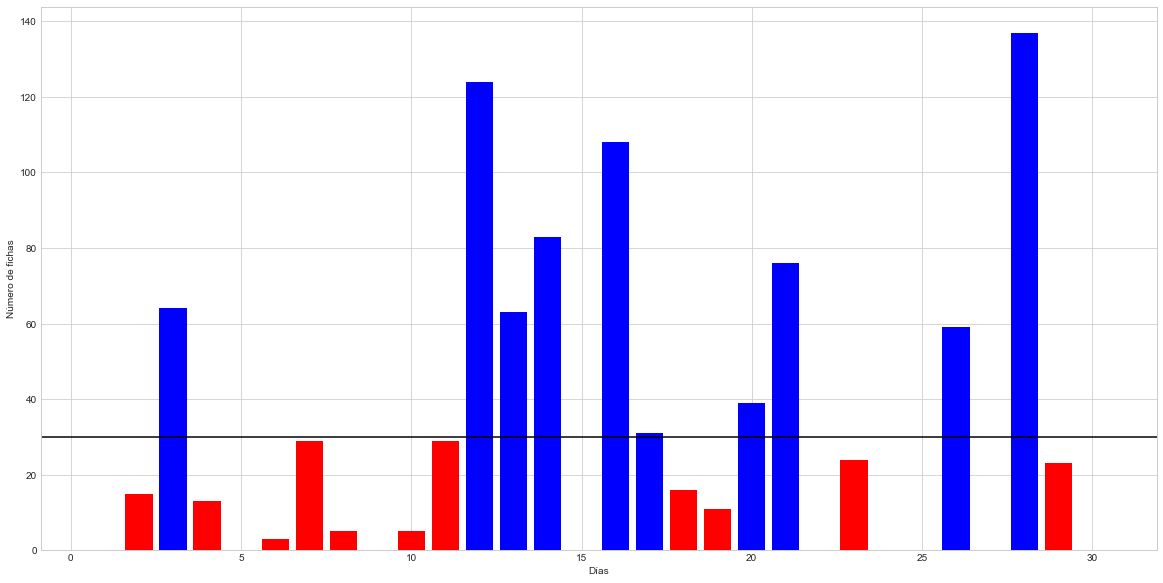

In [166]:
plot_bar_graph(df, INITIAL_CHIPS)

En el gráfico anterior se muestran en el eje x los diferentes días del mes. En el eje y se muestra el número de fichas con las que el jugador salio del casino cada uno de los días. La línea negra muestra el número de fichas con el que el jugador entró al casino. Las barras coloreadas de color rojo son los días malos de nuestro jugador en los cuales perdió fichas. Por otro lado, los días con barras azules son días en los que el jugador obtuvo beneficio. Si un día no muestra barra es por que el jugador se fue ese día sin ninguna ficha. 

Respondiendo a la pregunta, el número de noches en las que el jugador se ha tenido que retirar por que se ha quedado sin dinero es el siguiente: 

In [167]:
show_results(df, INITIAL_CHIPS, LEAVE_WITH_MAX)

Número de noches que el jugador perdió todas las fichas: 9
Porcentaje de noches que el jugador perdió todas las fichas: 30.0%
Número de noches que el jugador perdió fichas: 20
Porcentaje de noches que el jugador perdió fichas: 66.67%
Número de noches que el jugador salió igual del casino: 0
Porcentaje de noches que el jugador salió igual del casino: 0.0%
Número de noches que el jugador ganó fichas: 10
Porcentaje de noches que el jugador ganó fichas: 33.33%
Número de noches que el jugador se retiró alcanzando el máximo de fichas: 0
Porcentaje de noches que el jugador se retiró alcanzando el máximo de fichas: 0.0%


###        b) ¿Cuál es el número de fichas con las que ha finalizado las noches de ese mes y cómo se distribuye (representar el histograma)?

En el gráfico anterior se mostró cuales eran las fichas que nuestro jugador había sido capaz de llevarse a casa para cada uno de los días del mes. 
Vamos a aprovechar esta pregunta para visualizar la evolución de la cantidad de fichas que tuvo nuestro jugador a lo largo de cada uno de los días en el casino. 

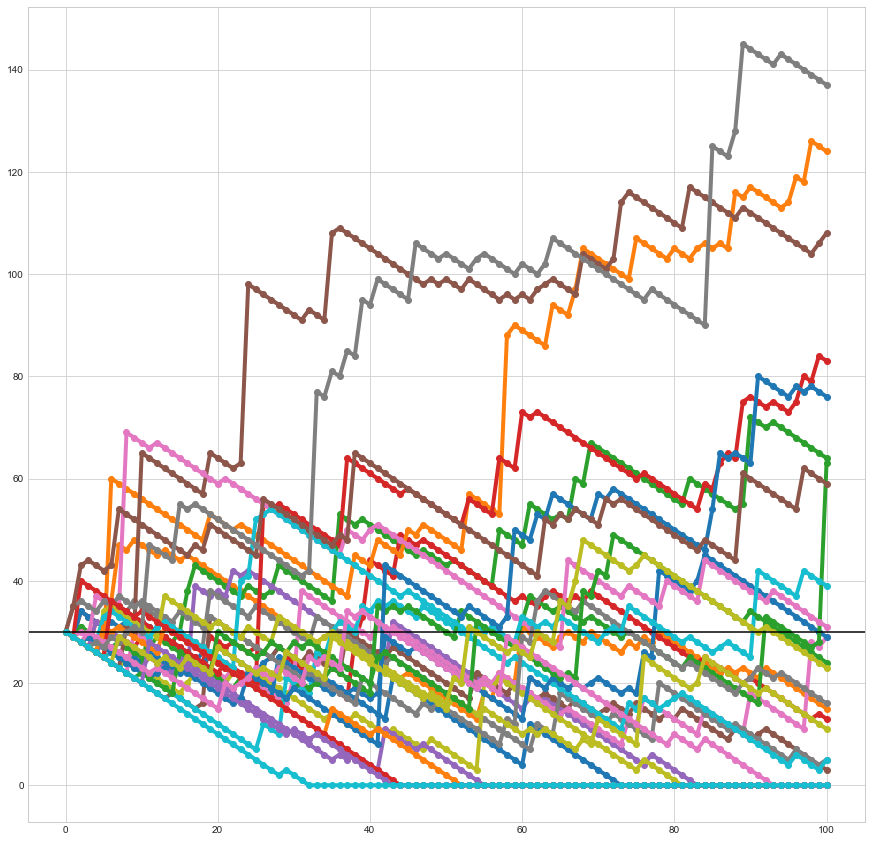

In [168]:
plot_chips_evolution(chips)

Por último, vamos a mostra rle histograma de frecuencia de la cantidad de fichas con las que le jugador es capaz de salir del casino a lo largo de un mes. 

(0, 209.0079169490293)

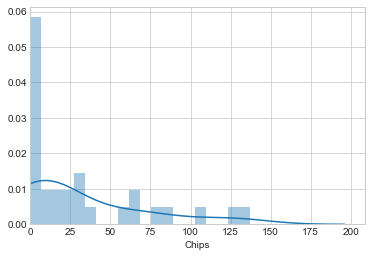

In [191]:
sns.distplot(df['Chips'], bins = 20);plt.xlim(0,None)

###           c) ¿Cuál es el número medio de partidas jugadas antes de retirarse por quedarse sin dinero?

In [170]:
ruined = df[df['Chips'] == 0]
ruined

,Day,Chips,Games,Benefit,Improvement
0,1,0,73,-30,-1.0
4,5,0,83,-30,-1.0
8,9,0,81,-30,-1.0
14,15,0,55,-30,-1.0
21,22,0,52,-30,-1.0
23,24,0,44,-30,-1.0
24,25,0,43,-30,-1.0
26,27,0,93,-30,-1.0
29,30,0,32,-30,-1.0


In [185]:
"El jugador se ha arruinado "+ str(ruined.shape[0]) +" veces, jugando de media " + str(round(ruined["Games"].mean(),2)) + " días antes de arruinarse."

'El jugador se ha arruinado 9 veces, jugando de media 61.78 días antes de arruinarse.'

###           Estadísticos de esta primera simulación
Aunque esta sección no estaba requerida en el enunicado de la memoria a continuación se muestran  diferentes estadísticos sencillos que pueden ayudarnos a comprender mejor el resultado de la simulación. 

In [159]:
df.describe()

,Day,Chips,Games,Benefit,Improvement
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,15.500000,35.200000,84.400000,5.200000,0.173333
std,8.803408,32.238764,22.681604,32.238764,1.074625
min,1.000000,0.000000,37.000000,-30.000000,-1.000000
25%,8.250000,0.000000,68.000000,-30.000000,-1.000000
50%,15.500000,39.000000,100.000000,9.000000,0.300000
75%,22.750000,62.000000,100.000000,32.000000,1.066667
max,30.000000,98.000000,100.000000,68.000000,2.266667


##### La siguiente celda muestra los imports necesarios para poder ejecutar el agoritmo

In [ ]:
import graficos as gf
from random import randrange
import algoritmos as al
import numpy as np



### Seleccionar las características del algoritmo

#### Seleccionar la función a optimizar, definir el intervalo.

In [ ]:
NUM_NOCHES = 50
ALGORITMO = al.recocido_simulado_memory
VECINDAD = al.vecindad
VALOR_INICIAL = al.inicializador_aleatorio(INTERVALO)
P_ACEPTACION = al.probabilidad_aceptacion

### Ejecución del algoritmo

In [ ]:
x, y, valores_x, valores_y, valores_t = ALGORITMO(FUNCION, VECINDAD, VALOR_INICIAL, P_ACEPTACION, NUM_ITERACIONES, 2)

### Visualización de los resultados del algoritmo

In [ ]:
gf.plot_results(FUNCION, INTERVALO, valores_x, valores_y, valores_t, x, y)

In [ ]:
R2 = random
R2.seed(200)

In [ ]:
R1.random()

In [ ]:
R2.random()